In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import os
import json
from PIL import Image, ImageOps
import collections

In [10]:
def load_routes(version="newest"):
    saved_routes = os.listdir("saved_routes")
    if version == "newest":
        version = sorted(saved_routes)[-1]
    with open(os.path.join('saved_routes',version), 'r') as f:
        # write the dictionary to the file in JSON format
        routes = json.load(f)
    return routes

def load_hold_setup(version="newest",return_version=False):
    saved_hold_setups = os.listdir("saved_hold_setups")
    if version == "newest":
        version = sorted(saved_hold_setups)[-1]
    with open(os.path.join('saved_hold_setups',version), 'r') as f:
        # write the dictionary to the file in JSON format
        home_wall = json.load(f)
    return home_wall, version.strip(".json")

def get_coordinates():
    h_hole_distance = [15]+[20]*11
    h_cumulative_hole_distance = [np.sum(h_hole_distance[:i+1]) for i in range(len(h_hole_distance))]
    v_hole_distance = [5]+[20]*14
    v_cumulative_hole_distance = [np.sum(v_hole_distance[:i+1]) for i in range(len(v_hole_distance))]
    return h_cumulative_hole_distance, v_cumulative_hole_distance

def plot_background(ax):
    ax.axis("off")
    # wandpanele
    for base_h in [0,150]:
        ax.plot([0,250,250,0,0],np.array([0,0,150,150,0])+base_h,color="k",linewidth=1.5,zorder=1)
    # doka tafeln einzeln
    for base_h in [0,50,100,150,200,250]:
        ax.plot([0,250,250,0,0],np.array([0,0,50,50,0])+base_h,color="grey",linewidth=.75,zorder=0)
    h_cumulative_hole_distance, v_cumulative_hole_distance = get_coordinates()
    # coordinaten
    alphabeth = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    for i,h in enumerate(h_cumulative_hole_distance):
        ax.text(h,310,alphabeth[i],va="center",ha="center")
        ax.text(h,-10,alphabeth[i],va="center",ha="center")
    for i,v in enumerate(v_cumulative_hole_distance):
        ax.text(-10,v,f"{i+1}",va="center",ha="center")
        ax.text(260,v,f"{i+1}",va="center",ha="center")

def plot_all_holds(ax,holds):
    for hold_coords, hold in holds.items():
        plot_hold(ax,hold)
        
def trim_whitespace(path,padding=0):
    # Code from 
    # https://gist.github.com/thomastweets/c7680e41ed88452d3c63401bb35116ed
    
    padding = np.array([-1*padding, -1*padding, padding, padding])

    image=Image.open(path)
    image.load()
    imageSize = image.size
    # remove alpha channel
    invert_im = image.convert("RGB") 

    # invert image (so that white is 0)
    invert_im = ImageOps.invert(invert_im)
    imageBox = invert_im.getbbox()
    imageBox = tuple(np.asarray(imageBox)+padding)

    cropped=image.crop(imageBox)
    # print("Size:", imageSize, "New Size:", imageBox)
    cropped.save(path)
    
def plot_hold(ax,hold,text=False,fade=False):
    x,y = hold["plot_coords"]
    ax.scatter(x,y,color=hold["plot_color"],s=hold["plot_size"],edgecolor="k",linewidth=1)
    if fade:
        ax.scatter(x,y,color="w",s=hold["plot_size"]+30,edgecolor="k",linewidth=0,alpha=.75)
        # plt.scatter(*get_plot_coords(wall_coords),color="w",linewidth=0,s=s+30,alpha=1-alpha)
    if text:
        if hold["hold_size"] == "S":
            text_size = 5
        elif hold["hold_size"] == "M":
            text_size = 7
        elif hold["hold_size"] == "L":
            text_size = 9
        txt = ax.text(x+.1,y-.5,text, size=text_size, color='black',va="center",ha="center")
        txt.set_path_effects([PathEffects.withStroke(linewidth=text_size/8, foreground='w')])

In [18]:
home_wall,version = load_hold_setup(return_version=True)

# Plot Home Wall

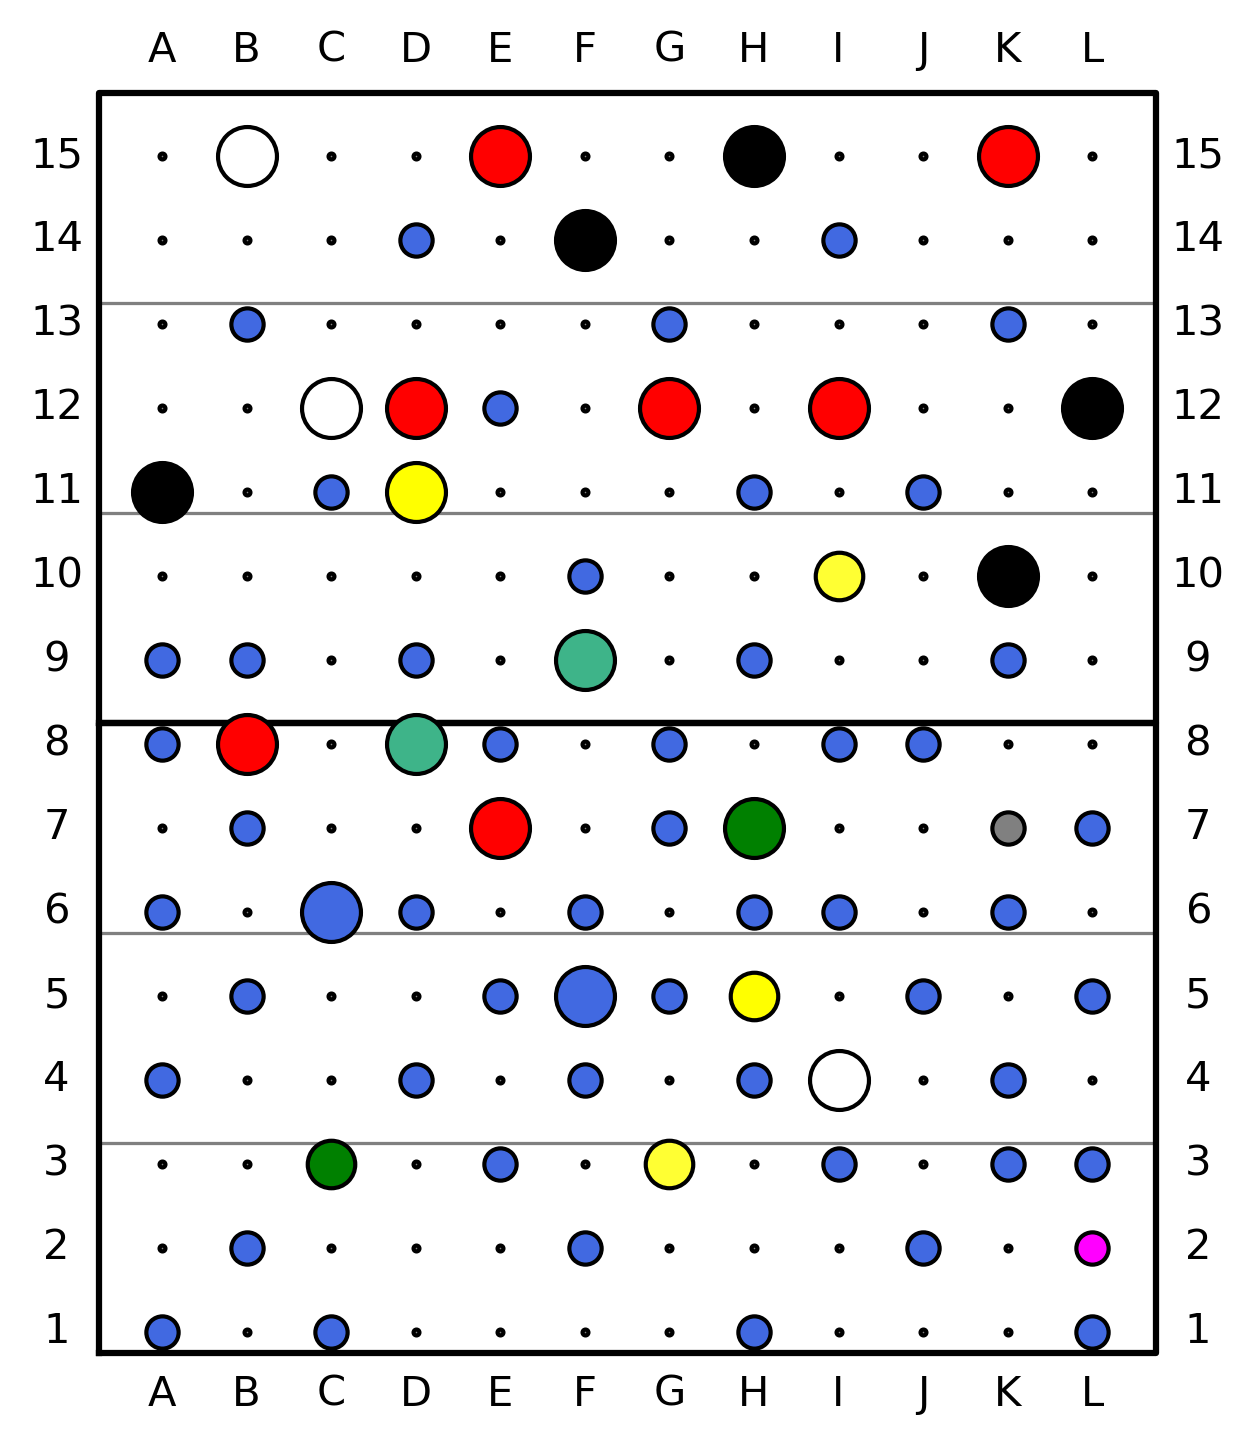

In [12]:
fig = plt.figure(dpi=300,figsize=(5,6))
ax = fig.add_subplot(111)
plot_background(ax)
plot_all_holds(ax,home_wall)
full_wall_path = f"plots/{version}_full_wall.png"
fig.savefig(full_wall_path)
trim_whitespace(full_wall_path,10)
fig.show()

# Plot Routes

Potential 6C
Isi Cheezy
Day 1 Fun
done


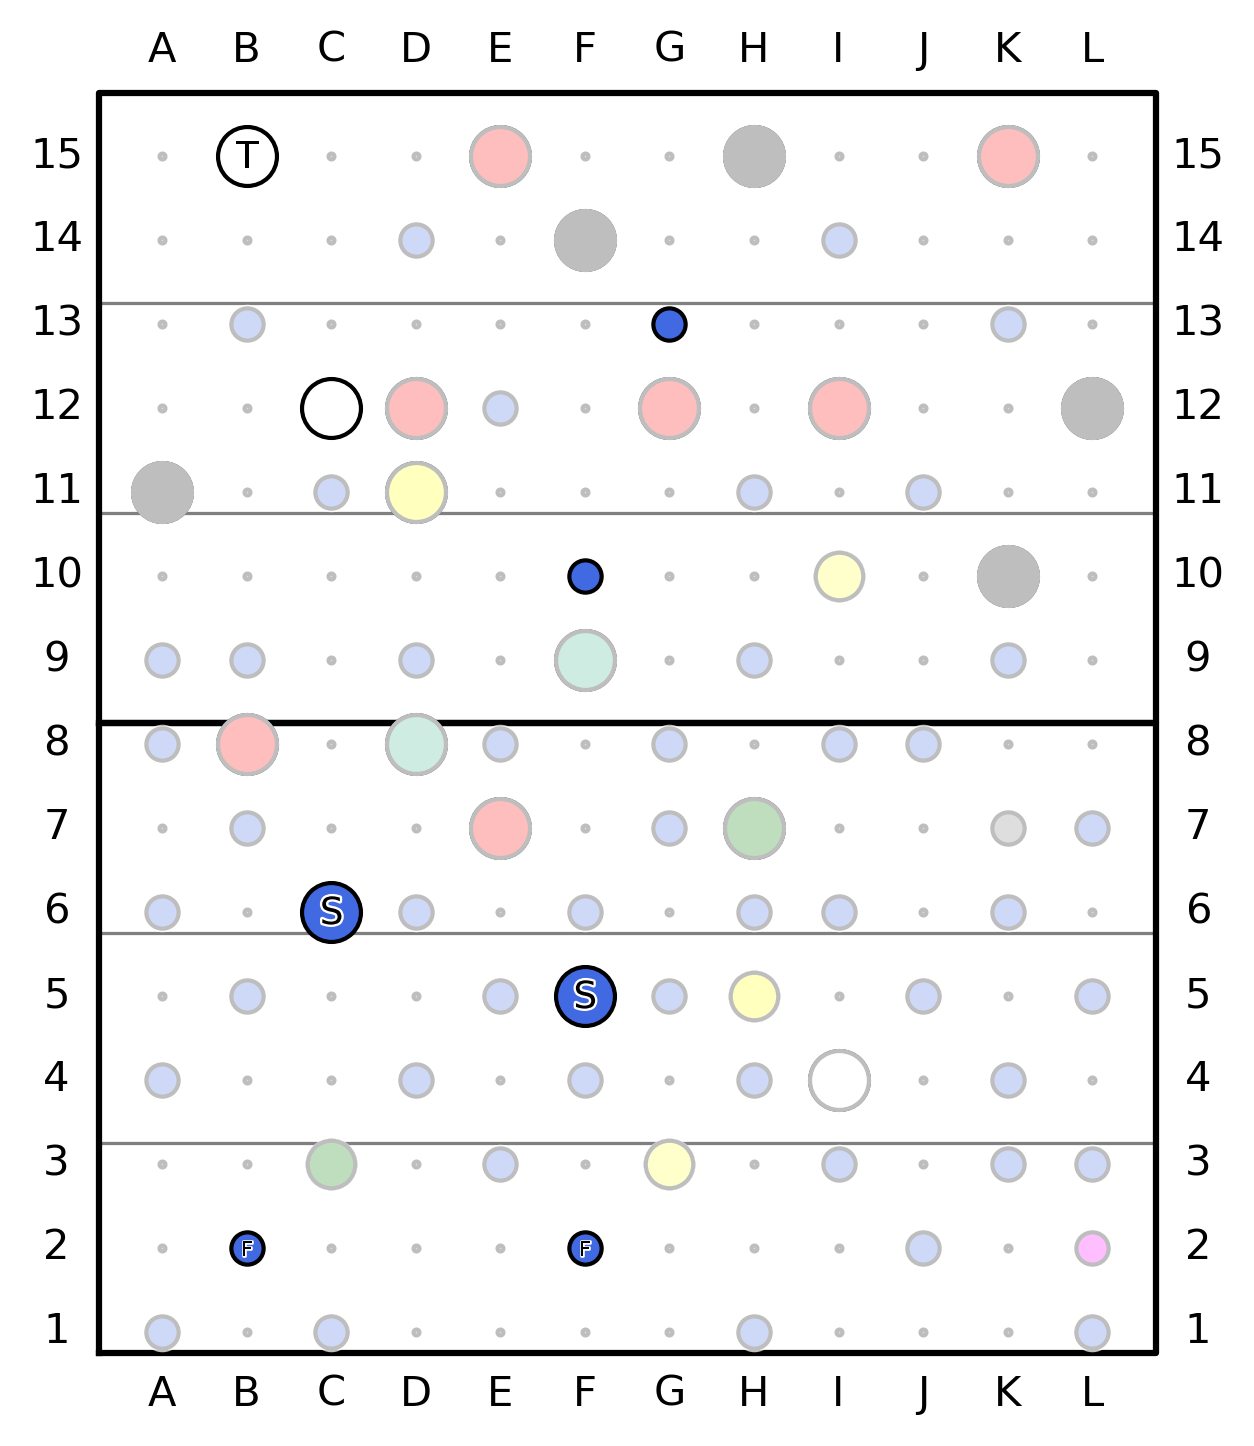

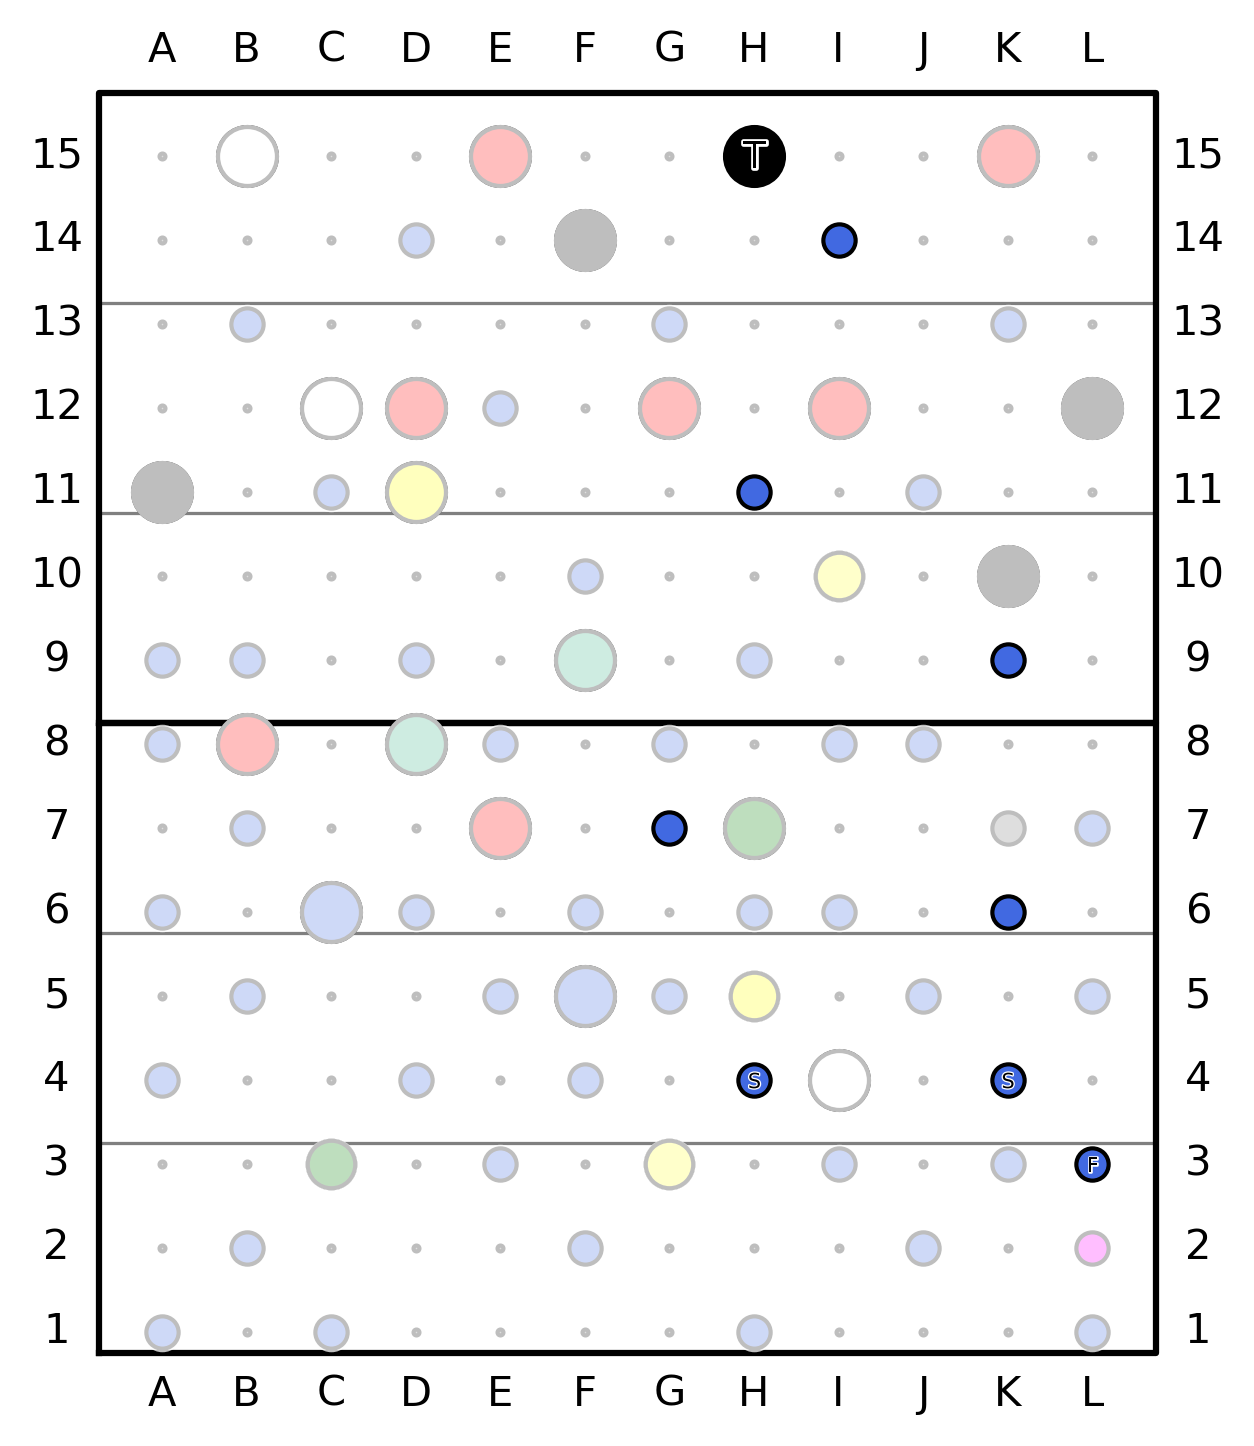

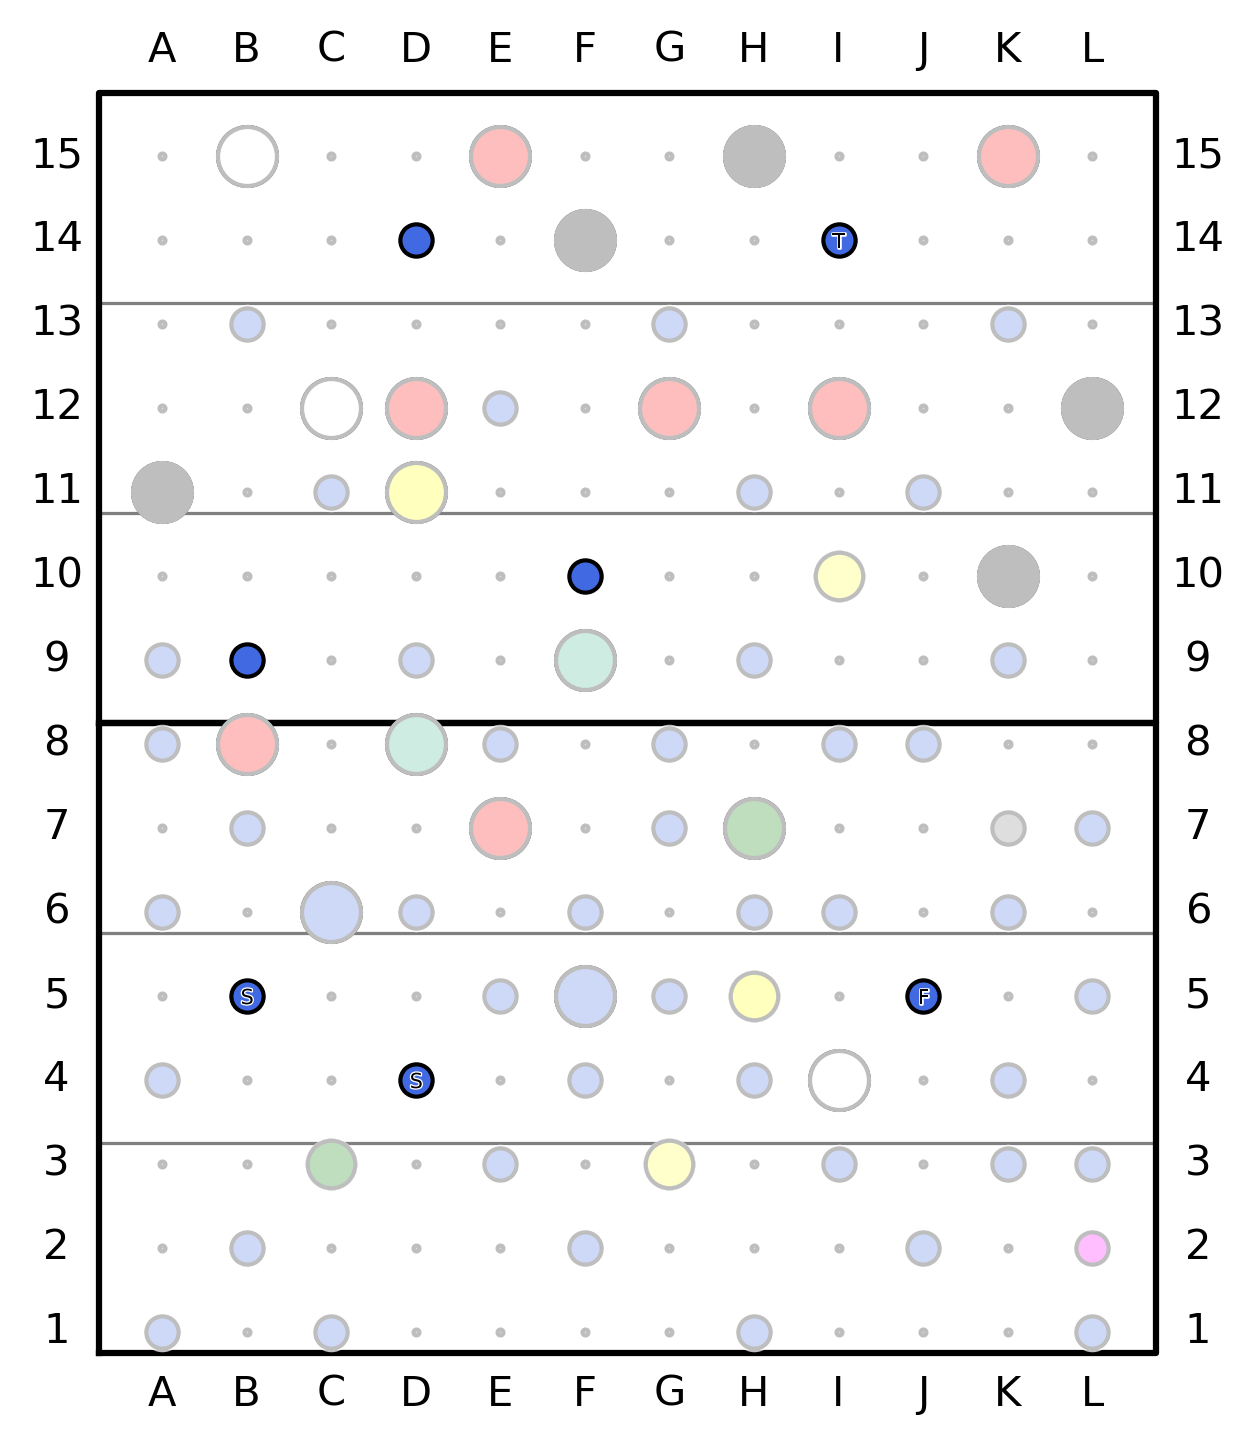

In [22]:
routes = load_routes()

def plot_route(route_name,route,save=False):
    
    fig = plt.figure(dpi=300,figsize=(5,6))
    ax = fig.add_subplot(111)
    plot_background(ax)
    for hold in route["start"]:
        plot_hold(ax,home_wall[hold],text="S")
    for hold in route["top"]:
        plot_hold(ax,home_wall[hold],text="T")
    for hold in route["hands"]:
        plot_hold(ax,home_wall[hold])
    for hold in route["feet"]:
        plot_hold(ax,home_wall[hold],text="F")
    used_hold_coords = route["start"]+route["top"]+route["hands"]+route["feet"]
    for hold_coord, hold in home_wall.items():
        if hold_coord not in used_hold_coords:
            plot_hold(ax,hold,fade=True)
    tmp_route_path = f"plots/{version}_{route['route_id']}.png"
    if save:
        fig.savefig(tmp_route_path)
        trim_whitespace(tmp_route_path,10)
    return tmp_route_path


ROUTES  = "\n\n# Routes\n\n"
ROUTES += "| Name | Grade | Tag |\n"
ROUTES += "| ---- | ----- | --- |\n"
for route_name, route in routes.items():
    print(route_name)
    tmp_route_path = plot_route(route_name,route,save=False)
    tmp_markdown_path = f"markdowns/{version}_{route['route_id']}.md"
    comment = route['comment']
    if len(comment) == 0:
        comment = "-"
    
    
    ROUTE  = f"# {route_name} ({route['grade']})\n\n"
    ROUTE += "| - | Info |\n"
    ROUTE += "| - | ---- |\n"
    ROUTE += f"| Grade | {route['grade']}|\n"
    ROUTE += f"| Tag | {route['tag']}|\n"
    ROUTE += f"| Comment | {comment}|\n"
    ROUTE += f"| Established | {route['established']} |\n\n"
    ROUTE += f"![{route['route_id']}](/{tmp_route_path})\n\n"
    ROUTES += f"| [{route_name}](/{tmp_markdown_path}) | {route['grade']} | {route['tag']} |\n"
    
    with open(tmp_markdown_path,"w") as file:
        file.write(ROUTE)
    
    # break
ROUTES += "\n\n"
print("done")

# Create README

In [23]:
def print_home_wall_info(home_wall):
    text = ""
    mounted_holds = []
    hold_colors = []
    hold_sizes = []
    for hold_coords,info in home_wall.items():
        if info["hold_mounted"]:
            mounted_holds.append(hold_coords)
            hold_colors.append(info["hold_color"])
            hold_sizes.append(info["hold_size"])
    nr_mounts = len(home_wall.keys())
    nr_mounted = len(mounted_holds)
    text += "\n\n| - | Nr. | % | \n"
    text += "|---|---|---|\n"
    text += f"| Einschlagmuttern | {nr_mounts:3.0f}  | {nr_mounts/nr_mounts*100:3.0f}% |\n"
    text += f"| Griffe           | {nr_mounted:3.0f} | {nr_mounted/nr_mounts*100:3.0f}% |\n\n"
    text += "|Grifffarben | Nr. | % |\n"
    text += "|---|---|---|\n"
    # print(f"Nr. Einschlagmuttern = {nr_mounts:3.0f}")
    # print(f"Nr. Griffe           = {nr_mounted:3.0f} ({nr_mounted/nr_mounts*100:3.0f}%)")
    # print("Grifffarben")
    for (color,nr) in collections.Counter(hold_colors).most_common():
        # print(f"{color:>10} = {nr:3.0f} ({nr/nr_mounted*100:2.0f}%)")
        text += f"|{color:>10} | {nr:3.0f} |{nr/nr_mounted*100:2.0f}%|\n"
    # print("Griffgrößen")
    text += "\n|Griffgrößen | Nr. | % |\n"
    text += "|---|---|---|\n"
    for (color,nr) in collections.Counter(hold_sizes).most_common():
        text += f"|{color:>10} | {nr:3.0f} | {nr/nr_mounted*100:2.0f}% |\n"
        # print(f"{color:>10} = {nr:3.0f} ({nr/nr_mounted*100:2.0f}%)")
    return text

In [24]:
README = "# My Bouldering Home Wall\n"
README += f"This is my setup as of {version}.\n\n"
README += f"![full_wall]({full_wall_path})\n\n"

README += ROUTES

README += "# Statistics\n"
README += "## Wall Statistics\n"
README += print_home_wall_info(home_wall)

with open("README.md","w") as file:
    file.write(README)